In [66]:
import pandas as pd
import pickle
import numpy as np
import random
from skimage.feature import hog

import cv2

In [67]:
## 이미지 로드를 위한 함수들
from os import listdir
from os.path import isfile, join

## 지정된 폴더 내부의 모든 이미지 파일의 Path를 읽어오는 함수
def get_sample_datalist(path='./'):
    print('Getting sample data list..')
    imagefile_path_list = [f for f in listdir(path) if isfile(join(path, f))]

    return imagefile_path_list

## 입력된 모든 Path에 대응되는 이미지를 읽어오는 함수
def load_my_data(imagefile_path_list, test=None):
    print('load_my_data')
    x = []
    for path in imagefile_path_list:
        img = cv2.imread(path)

        #이미지는 256x256으로 모두 리사이즈
        if img.shape[:2] != (256,256):
            img = cv2.resize(img, (256,256))
        x.append(img)
        
    return x

In [68]:
## Color Histogram을 추출하는 함수 - 자세한 내용은 Coding Lab 수업 참고
def get_color_histogram(x):

  hist_feature = []

  for i in range(len(x)):

    curr_img_hsv = cv2.cvtColor(x[i], cv2.COLOR_BGR2HSV)
    
    curr_hist = cv2.calcHist([curr_img_hsv], [0], None, [20], [0, 180])

    curr_hist = curr_hist.squeeze().astype(np.float64)

    hist_feature.append(curr_hist/np.sum(curr_hist))

  return hist_feature

In [70]:
## HOG Feature를 추출하는 함수 - 자세한 내용은 Coding Lab 수업 참고
def get_hog_feature(x):

  hog_feature = []

  for i in range(len(x)):

    curr_img_hsv = cv2.cvtColor(x[i], cv2.COLOR_BGR2HSV)

    _, curr_hog = hog(curr_img_hsv[:,:,2], orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, multichannel=False)  
    
    curr_hog = np.reshape(curr_hog, [-1])

    hog_feature.append(curr_hog)

  return hog_feature 

In [71]:
## 본 프로그램 시작
# 현재 위치의 모든 이미지 파일을 Query Image로 읽어오기
x_pathlist = get_sample_datalist()
x = load_my_data(x_pathlist)

# Color histogram 추출 (Query)
color_hist = get_color_histogram(x)

# HOG feature 추출 (Query)
hog_feature = get_hog_feature(x)

Getting sample data list..
load_my_data


load_my_data


Text(0.5, 1.0, 'Target Image')

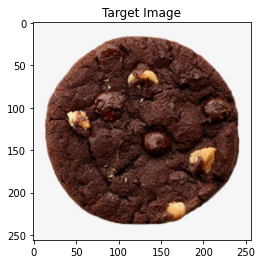

In [72]:
from matplotlib import pyplot as plt

# Target Image Loading...
target_image_path = ['./쿠키.jpg']
img_target = load_my_data(target_image_path)

# Target Image Showing...
plt.imshow(img_target[0][:,:,::-1])
plt.title('Target Image')

[0.28578877 0.49049123 0.15688278 0.16922733 0.37745672 0.27204004
 0.         0.00645953 0.00642091]
[6 8 7 2 3 5 0 4 1]
load_my_data


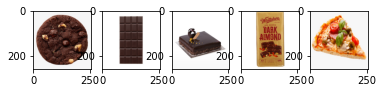

In [73]:
# Target Image Matching...(color histogram)
color_hist_target = get_color_histogram(img_target)[0]

# 모든 이미지마다 color histogram 추출 후, target이 되는 이미지의 color histogram과 query image 각각의 color histogram마다 분포 차이를 계산해서 제곱하여 합한다.
# 그 개별 값들을 distance 배열에 넣고
distance = np.sum((color_hist_target-color_hist)*(color_hist_target-color_hist), 1)

# distance가 작은 것, 즉 target image와 색상 차이가 적은 것부터 argsort 함수를 사용하여 오름차순으로 순위를 매겨주도록 한다.
idx = np.argsort(distance)

print(distance)
print(idx)

# Retrieval result showing...
NUM_CANDIDATE = 5
query_images = load_my_data(x_pathlist)
for i in range(NUM_CANDIDATE):
  plt.subplot(1,NUM_CANDIDATE,i+1)
  plt.imshow(query_images[idx[i]][:,:,::-1])

[1459315.46300277 1667590.45646085 1942814.66600688 1671578.3463892
 1488384.71695078 1965532.40751159       0.         2276400.29334687
 1994206.10127325]
[6 0 4 1 3 2 5 8 7]
load_my_data


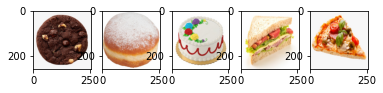

In [74]:
# Target Image Matching...(HOG feature...)
hog_feature_target = get_hog_feature(img_target)[0]

# 모든 이미지마다 HOG feature을 추출 후, target이 되는 이미지의 HOG feature과 query image 각각의 HOG feature마다 분포 차이를 계산해서 제곱하여 합한다.
# 그 개별 값들을 distance_hog 배열에 넣고
distance_hog = np.sum((hog_feature_target-hog_feature)*(hog_feature_target-hog_feature), 1)

# distance_hog가 작은 것, 즉 target image와 gradient(형태, 윤곽선) 차이가 적은 것부터 argsort 함수를 사용하여 오름차순으로 순위를 매겨주도록 한다.
idx_hog = np.argsort(distance_hog)

print(distance_hog)
print(idx_hog)

# Retrieval result showing...
NUM_CANDIDATE = 5
query_images = load_my_data(x_pathlist)
for i in range(NUM_CANDIDATE):
  plt.subplot(1,NUM_CANDIDATE,i+1)
  plt.imshow(query_images[idx_hog[i]][:,:,::-1])